In [1]:
import collections
import itertools
import json
import pathlib
import pickle

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker
import ml_collections
import numpy as np
import pandas as pd
import torch

import hier
import hier_torch
import infer
import main
import metrics
import progmet
import tree_util

In [2]:
Experiment = collections.namedtuple('Experiment', ['root', 'pattern'])
Trial = collections.namedtuple('Trial', ['root', 'config_file', 'model_file'])

In [36]:
EXP_ROOT = pathlib.Path('/mnt/ssd1/projects/2022-01-hierarchical/experiments')
PLOT_DIR = 'output/plots/inat21mini-res18-ep20-repeat/'
experiment_defs = {
    'flat_softmax': Experiment(
        EXP_ROOT / '2022-05-07-inat21mini-errorbar', 'flat_softmax-b64-lr0.01-wd0.0003-s*'),
    'multilabel_focal': Experiment(
        EXP_ROOT / '2022-03-31-inat21mini-dgx', 'multilabel_focal-0.9-1-lr-0.01-b-64-wd-0.0003-ep-20'),
    'hier_softmax': Experiment(
        EXP_ROOT / '2022-05-07-inat21mini-errorbar', 'hier_softmax-b64-lr0.01-wd0.0003-s*'),
    'cond_multilabel': Experiment(
        EXP_ROOT / '2022-05-07-inat21mini-errorbar', 'cond_multilabel-b64-lr0.01-wd0.0003-s*'),
    'descendant_softmax': Experiment(
        EXP_ROOT / '2022-05-07-inat21mini-errorbar', 'descendant_softmax-b64-lr0.01-wd0.0003-s*'),
    'descendant_softmax_complement': Experiment(
        EXP_ROOT / '2022-05-07-inat21mini-errorbar', 'descendant_softmax_complement-b64-lr0.01-wd0.0003-s*'),
    'soft_margin-incorrect-5': Experiment(
        EXP_ROOT / '2022-05-07-inat21mini-errorbar', 'soft_margin-incorrect-5-b64-lr0.01-wd0.0003-s*'),
#     '': Experiment(
#         EXP_ROOT / '', ''),
}

method_titles = {
    'flat_softmax': 'Flat',
    'multilabel_focal': 'Multilabel (focal)',
    'hier_softmax': 'Cond softmax',
    'cond_multilabel': 'Cond sigmoid',
    'descendant_softmax': 'Soft-max-descendant',
    'descendant_softmax_complement': 'Soft-max-descendant (cousin)',
    'soft_margin-incorrect-5': 'Soft-max-margin (correct)',
}

colors = dict(zip(
    experiment_defs,
    map(matplotlib.cm.get_cmap('tab10'), itertools.count())))

In [37]:
trial_names = {
    exp_name: sorted([
        path.name for path in exp_def.root.glob(exp_def.pattern)
        if (path / 'checkpoints/epoch-0020.pth').exists()
    ]) for exp_name, exp_def in experiment_defs.items()
}

trials = {
    exp_name: {
        trial_name: Trial(
            root=experiment_defs[exp_name].root / trial_name,
            config_file=experiment_defs[exp_name].root / trial_name / 'config.json',
            model_file=experiment_defs[exp_name].root / trial_name / 'checkpoints/epoch-0020.pth')
        for trial_name in trial_names[exp_name]
    } for exp_name in trial_names
}

In [38]:
device = torch.device('cuda')

In [39]:
import configs.inaturalist2021mini

base_config = configs.inaturalist2021mini.get_config()
base_config.dataset_root = '/home/jack/data/manual/inaturalist2021/'

_, eval_dataset, tree, _, _, eval_label_map = main.make_datasets(base_config)

In [40]:
eval_loader = torch.utils.data.DataLoader(
    dataset=eval_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2)

In [41]:
is_leaf = tree.leaf_mask()
specificity = np.log2(tree.num_leaf_nodes()) - np.log2(tree.num_leaf_descendants())
not_trivial = (tree.num_children() != 1)
subtract_children_cpu = hier_torch.SubtractChildren(tree)
subtract_children_cuda = hier_torch.SubtractChildren(tree).cuda()

In [42]:
gt_nodes = np.arange(tree.num_nodes())[:, None]
pr_nodes = np.arange(tree.num_nodes())[None, :]

matrix_correct_recall = (
    metrics.correct(tree, gt_nodes, pr_nodes).astype(np.float32) *
    metrics.LCAMetric(tree, specificity.astype(np.float32)).recall(gt_nodes, pr_nodes)
)
# matrix_info_f1 = (
#     metrics.LCAMetric(tree, specificity.astype(np.float32)).f1(gt_nodes, pr_nodes))
# matrix_correct_info = (
#     metrics.correct(tree, gt_nodes, pr_nodes) * specificity[pr_nodes]
# )

matrix_correct_recall = torch.from_numpy(matrix_correct_recall).cuda()

KeyboardInterrupt: 

In [43]:
infer_fns = {
    'leaf': lambda p: infer.argmax_where(p, is_leaf),
    'exclusive': lambda p: np.argmax(subtract_children_cpu(torch.from_numpy(p)).numpy(), axis=-1),
    'majority': lambda p: infer.argmax_with_confidence(specificity, p, 0.5, not_trivial),
    'plurality': lambda p: infer.argmax_where(
        specificity, not_trivial & (p > infer.plurality_threshold(tree, p, keepdims=True))),
    'expected': lambda p: infer.argmax_where(p * specificity, not_trivial),
    'crm_correct_recall': lambda p: (
        infer.argmax_where(
            torch.tensordot(
                subtract_children_cuda(torch.from_numpy(p).cuda()),
                matrix_correct_recall,
                1,
            ).cpu().numpy(),
            not_trivial)),
    # 'crm_info_f1': lambda p: infer.argmax_where(np.dot(p, matrix_info_f1), not_trivial),
    # 'crm_correct_info': lambda p: infer.argmax_where(np.dot(p, matrix_correct_info), not_trivial),
}

markers = {
    'leaf': 'o',
    'exclusive': 'x',
    'majority': '^',
    'plurality': '>',
    'expected': 'd',
    'crm_correct_recall': '+',
}

inference_titles = {
    'leaf': 'Leaf',
    'exclusive': 'Exclusive',
    'majority': 'Majority',
    'plurality': 'Plurality',
    'expected': 'Expected info',
    'crm_correct_recall': 'Cond risk (correct info)',
}

In [44]:
info_metric = metrics.UniformLeafInfoMetric(tree)
depth_metric = metrics.DepthMetric(tree)

metric_fns = {
    'exact': lambda gt, pr: pr == gt,
    'correct': metrics.IsCorrect(tree),
    'info_excess': info_metric.excess,
    'info_deficient': info_metric.deficient,
    'info_dist': info_metric.dist,
    'info_recall': info_metric.recall,
    'info_precision': info_metric.precision,
    'info_f1': info_metric.f1,
    'depth_excess': depth_metric.excess,
    'depth_deficient': depth_metric.deficient,
    'depth_dist': depth_metric.dist,
    'depth_recall': depth_metric.recall,
    'depth_precision': depth_metric.precision,
    'depth_f1': depth_metric.f1,
}

metric_titles = {
    'exact': 'Exact',
    'correct': 'Correct',
    'info_recall': 'Information Recall',
    'info_precision': 'Information Precision',
    'depth_recall': 'Depth Recall',
    'depth_precision': 'Depth Precision',
    'info_lca': 'LCA Information',
    'depth_lca': 'LCA Depth',
}

In [45]:
def apply_model(net, pred_fn, min_threshold, limit=None):
    # Per-example predictions.

    outputs = {
        'gt': [],  # Node in hierarchy.
        'pred': {method: [] for method in infer_fns},
    }
    # Sequence-per-example predictions. Cannot be concatenated due to ragged shape.
    seq_outputs = {
        'pred': [],
        'prob': [],
    }

    net.eval()
    with torch.inference_mode():
        meter = progmet.ProgressMeter('apply', interval_time=5)
        for minibatch in itertools.islice(meter(eval_loader), limit):
            inputs, gt_labels = minibatch
            theta = net(inputs.to(device))
            prob = pred_fn(theta).cpu().numpy()
            pred = {}
            for name, infer_fn in infer_fns.items():
                pred[name] = infer_fn(prob)
            gt_node = eval_label_map.to_node[gt_labels]
            pred_seqs = [
                infer.pareto_optimal_predictions(specificity, p, min_threshold, not_trivial)
                for p in prob
            ]
            prob_seqs = [prob[i, pred_i] for i, pred_i in enumerate(pred_seqs)]
            # Caution: Predictions are *not* truncated.

            outputs['gt'].append(gt_node)
            for method in infer_fns:
                outputs['pred'][method].append(pred[method])
            seq_outputs['pred'].extend(pred_seqs)
            seq_outputs['prob'].extend(prob_seqs)

    # Concatenate results from minibatches.
    leaf_predicate = lambda x: not isinstance(x, dict)  # Treat lists as values, not containers.
    outputs = tree_util.tree_map(np.concatenate, outputs, is_leaf=leaf_predicate)

    return outputs, seq_outputs

In [46]:
def assess_predictions(outputs, seq_outputs):
    gt = outputs['gt']
    pred = outputs['pred']
    pred_seq = seq_outputs['pred']
    prob_seq = seq_outputs['prob']

    # Evaluate predictions for each method.
    pred = {
        method: hier.truncate_at_lca(tree, gt, pr)
        for method, pr in pred.items()
    }
    pred_metrics = {
        method: {field: np.mean(metric_fn(gt, pr))
                 for field, metric_fn in metric_fns.items()}
        for method, pr in pred.items()
    }

    # Evaluate predictions in Pareto sequence.
    find_lca = hier.FindLCA(tree)
    specificity_seq = [specificity[pr_i] for pr_i in pred_seq]
    pred_seq = [hier.truncate_given_lca(gt_i, pr_i, find_lca(gt_i, pr_i)) for gt_i, pr_i in zip(gt, pred_seq)]
    metric_values_seq = {
        field: [metric_fn(gt_i, pr_i) for gt_i, pr_i in zip(gt, pred_seq)]
        for field, metric_fn in metric_fns.items()
    }
    pareto_scores, pareto_totals = metrics.operating_curve(prob_seq, metric_values_seq)
    pareto_means = {k: v / len(gt) for k, v in pareto_totals.items()}

    return pred_metrics, pareto_scores, pareto_means

In [47]:
def update_config(config):  # For backwards compatibility.
    if not hasattr(config.train, 'loss_weighting'):
        setattr(config.train, 'loss_weighting', 'none')
    if not hasattr(config.train, 'margin_tau'):
        setattr(config.train, 'margin_tau', 1.0)
    return config  # For convenience.

def resample_threshold(scores, metric, x):
    return metric[np.searchsorted(-scores, -x)]

In [48]:
# Initialize results if not defined.
try:
    results
except NameError:
    results = {}  # Not defined.

In [49]:
# del results

In [50]:
MIN_THRESHOLD = None  # Values less than 0.5 may increase runtime significantly.
LIMIT = None
IGNORE_CACHE_FILE = False

score_grid = np.flip(np.linspace(0, 1, 1001))

for experiment_name in trials:
    for trial_name, trial in trials[experiment_name].items():
        key = (experiment_name, trial_name)
        if key in results:
            print('cached:', key)
            continue

        results_file = pathlib.Path(trial.root) / f'results-th-{MIN_THRESHOLD}-lim-{LIMIT}.pkl'
        if results_file.exists() and not IGNORE_CACHE_FILE:
            print('load from file:', str(results_file))
            # results[key] = dict(np.load(results_file, allow_pickle=True))
            with open(results_file, 'rb') as f: 
                trial_results = pickle.load(f)
        else:
            print('evaluate:', key)
            # Load model.
            with open(trial.config_file, 'r') as f:
                config = update_config(ml_collections.ConfigDict(json.load(f)))
            num_outputs = main.get_num_outputs(config.predict, tree)
            net = main.make_model(config.model, num_outputs)
            missing_keys, unexpected_keys = net.load_state_dict(torch.load(trial.model_file), strict=True)
            assert not missing_keys
            assert not unexpected_keys

            net.to(device)
            _, pred_fn = main.make_loss(config, tree, device)
            outputs, seq_outputs = apply_model(net, pred_fn, min_threshold=MIN_THRESHOLD, limit=LIMIT)
            pred_metrics, pareto_scores, pareto_metrics = assess_predictions(outputs, seq_outputs)
            trial_results = {
                'pred_metrics': pred_metrics,
                'pareto_scores': pareto_scores,
                'pareto_metrics': pareto_metrics,
            }
            # np.savez(results_file, **results[key])
            with open(results_file, 'wb') as f:
                pickle.dump(trial_results, f)

        # Re-sample the Pareto front; also keeps the memory footprint down.
        trial_results.update({
            'pareto_scores': score_grid[1:],
            'pareto_metrics': {
                field: resample_threshold(
                    trial_results['pareto_scores'],
                    trial_results['pareto_metrics'][field],
                    score_grid)
                for field in trial_results['pareto_metrics']
            },
        })
        results[key] = trial_results

cached: ('flat_softmax', 'flat_softmax-b64-lr0.01-wd0.0003-s0')
cached: ('flat_softmax', 'flat_softmax-b64-lr0.01-wd0.0003-s1')
cached: ('flat_softmax', 'flat_softmax-b64-lr0.01-wd0.0003-s2')
cached: ('flat_softmax', 'flat_softmax-b64-lr0.01-wd0.0003-s3')
cached: ('flat_softmax', 'flat_softmax-b64-lr0.01-wd0.0003-s4')
cached: ('multilabel_focal', 'multilabel_focal-0.9-1-lr-0.01-b-64-wd-0.0003-ep-20')
cached: ('hier_softmax', 'hier_softmax-b64-lr0.01-wd0.0003-s0')
cached: ('hier_softmax', 'hier_softmax-b64-lr0.01-wd0.0003-s1')
cached: ('hier_softmax', 'hier_softmax-b64-lr0.01-wd0.0003-s2')
cached: ('hier_softmax', 'hier_softmax-b64-lr0.01-wd0.0003-s3')
cached: ('hier_softmax', 'hier_softmax-b64-lr0.01-wd0.0003-s4')
cached: ('cond_multilabel', 'cond_multilabel-b64-lr0.01-wd0.0003-s0')
cached: ('cond_multilabel', 'cond_multilabel-b64-lr0.01-wd0.0003-s1')
cached: ('cond_multilabel', 'cond_multilabel-b64-lr0.01-wd0.0003-s2')
cached: ('cond_multilabel', 'cond_multilabel-b64-lr0.01-wd0.0003-s

In [51]:
# Compute statistics over trials.

pred_metrics = {
    trial_key + (inference_name,): results[trial_key]['pred_metrics'][inference_name]
    for trial_key in results
    for inference_name in infer_fns
}
pred_metrics = pd.DataFrame.from_dict(pred_metrics, orient='index').groupby(level=(0, 2)).describe()
pred_metrics_mean = pred_metrics.stack(0)['mean'].unstack().unstack()
pred_metrics_std = pred_metrics.stack(0)['std'].unstack().unstack()
pred_metrics_mean

correct                      \
                              crm_correct_recall exclusive  expected   
cond_multilabel                         0.682336  0.645234  0.755414   
descendant_softmax                      0.759632  0.527962  0.787812   
descendant_softmax_complement           0.746078  0.572362  0.782170   
flat_softmax                            0.762674  0.521716  0.762656   
hier_softmax                            0.723984  0.443082  0.723966   
multilabel_focal                        0.754900  0.429450  0.529710   
soft_margin-incorrect-5                 0.709588  0.530998  0.709586   

                                                             \
                                   leaf  majority plurality   
cond_multilabel                0.444680  0.808274  0.516450   
descendant_softmax             0.517472  0.870208  0.630494   
descendant_softmax_complement  0.522875  0.867138  0.631748   
flat_softmax                   0.521716  0.849040  0.601988   
hier_softmax                   0.443082  0.786326  0.495768   
multilabel_focal               0.429450  0.472870  0.516040   
soft_margin-incorrect-5        0.530998  0.793542  0.603626   

                                 depth_deficient                      \
                              crm_correct_recall exclusive  expected   
cond_multilabel                         2.869012  2.215280  2.494090   
descendant_softmax                      1.983530  1.702404  2.398578   
descendant_softmax_complement           1.919843  1.760563  2.391145   
flat_softmax                            1.939468  1.572574  1.939350   
hier_softmax                            2.386974  1.789674  2.386896   
multilabel_focal                        6.964830  1.870550  2.047590   
soft_margin-incorrect-5                 1.771356  1.584328  1.771286   

                                         ... info_precision            \
                                   leaf  ...       expected      leaf   
cond_multilabel                1.774510  ...       0.826897  0.655240   
descendant_softmax             1.574582  ...       0.840993  0.697171   
descendant_softmax_complement  1.562345  ...       0.836446  0.700079   
flat_softmax                   1.572574  ...       0.824203  0.698627   
hier_softmax                   1.789674  ...       0.801465  0.652651   
multilabel_focal               1.870520  ...       0.687742  0.637977   
soft_margin-incorrect-5        1.584328  ...       0.792337  0.698872   

                                                         info_recall  \
                               majority plurality crm_correct_recall   
cond_multilabel                0.891669  0.731682           0.470095   
descendant_softmax             0.923905  0.793246           0.628102   
descendant_softmax_complement  0.919521  0.791920           0.639473   
flat_softmax                   0.916476  0.779029           0.635011   
hier_softmax                   0.878799  0.715632           0.547201   
multilabel_focal               0.676006  0.715498           0.003138   
soft_margin-incorrect-5        0.882891  0.770584           0.667519   

                                                                       \
                              exclusive  expected      leaf  majority   
cond_multilabel                0.564752  0.523709  0.655240  0.476265   
descendant_softmax             0.695201  0.569631  0.697171  0.502089   
descendant_softmax_complement  0.689503  0.576144  0.700079  0.517387   
flat_softmax                   0.698627  0.635018  0.698627  0.564754   
hier_softmax                   0.652651  0.547193  0.652651  0.499291   
multilabel_focal               0.637976  0.613686  0.637977  0.608535   
soft_margin-incorrect-5        0.698872  0.667524  0.698872  0.629042   

                                         
                              plurality  
cond_multilabel                0.576050  
descendant_softmax             0.646816  
descendant_softmax_complement  0.657213  


In [52]:
INTEGRALS = {
    # 'AC(depth)': ('depth_recall', 'correct'),
    'AC(info)': ('info_recall', 'correct'),
    # 'AP(depth)': ('depth_recall', 'depth_precision'),
    'AP(info)': ('info_recall', 'info_precision'),
    'AC(exact)': ('exact', 'correct'),
}

auc = {
    integral_name: {
        trial_key: metrics.pareto_integrate(
            results[trial_key]['pareto_metrics'][x],
            results[trial_key]['pareto_metrics'][y])
        for trial_key in results
    } for integral_name, (x, y) in INTEGRALS.items()
}

# pd.DataFrame(auc).groupby(level=0).describe()
auc_mean = pd.DataFrame(auc).groupby(level=0).mean()
auc_std = pd.DataFrame(auc).groupby(level=0).std()
auc_mean

,AC(info),AP(info),AC(exact)
cond_multilabel,0.571285,0.606399,0.317070
descendant_softmax,0.634787,0.659978,0.399962
descendant_softmax_complement,0.641935,0.664552,0.409051
flat_softmax,0.647121,0.669003,0.446086
hier_softmax,0.574724,0.607170,0.321750
multilabel_focal,0.532537,0.575572,0.274511
soft_margin-incorrect-5,0.659703,0.676264,0.480606


In [53]:
INTERCEPTS = [
    'depth_recall',
    'info_recall',
    'exact',
]

CORRECT = [50, 80, 90, 95]

recalls = {
    (y, c): {
        trial_key: metrics.pareto_intercept(
            results[trial_key]['pareto_metrics']['correct'],
            results[trial_key]['pareto_metrics'][y],
            c / 100)
        for trial_key in results
    } for y in INTERCEPTS for c in CORRECT
}

# pd.DataFrame(recalls).groupby(level=0).describe().style.format('{:.3f}'.format)
intercept_mean = pd.DataFrame(recalls).groupby(level=0).mean()
intercept_std = pd.DataFrame(recalls).groupby(level=0).std()
# intercept_mean.columns = intercept_mean.columns.to_flat_index().map(lambda xs: '_'.join(map(str, xs)))
# intercept_std.columns = intercept_std.columns.to_flat_index().map(lambda xs: '_'.join(map(str, xs)))
intercept_mean

depth_recall                                \
                                        50        80        90        95   
cond_multilabel                   0.722087  0.626571  0.567942  0.516585   
descendant_softmax                0.775089  0.681418  0.612367  0.564646   
descendant_softmax_complement     0.776817  0.689901  0.619387  0.571601   
flat_softmax                      0.775389  0.707218  0.652168  0.599911   
hier_softmax                      0.724775  0.632377  0.576912  0.525331   
multilabel_focal                  0.698559  0.576896  0.511349  0.457973   
soft_margin-incorrect-5           0.773798  0.723443  0.673297  0.621845   

                              info_recall                                \
                                       50        80        90        95   
cond_multilabel                  0.621616  0.481175  0.405228  0.342864   
descendant_softmax               0.697219  0.573031  0.478049  0.418035   
descendant_softmax_complement    0.700090  0.586421  0.491479  0.432883   
flat_softmax                     0.698679  0.597209  0.524407  0.458772   
hier_softmax                     0.626265  0.491812  0.420345  0.357119   
multilabel_focal                 0.591741  0.411265  0.328373  0.269431   
soft_margin-incorrect-5          0.699036  0.626081  0.565325  0.506455   

                                  exact                                
                                     50        80        90        95  
cond_multilabel                0.374768  0.161610  0.081642  0.036892  
descendant_softmax             0.517472  0.248640  0.115474  0.069962  
descendant_softmax_complement  0.522875  0.264820  0.120210  0.075513  
flat_softmax                   0.521716  0.356894  0.273488  0.206410  
hier_softmax                   0.382210  0.175084  0.098928  0.049620  
multilabel_focal               0.315540  0.084720  0.033820  0.013110  
soft_margin-incorrect-5        0.530998  0.426290  0.364252  0.309544

In [76]:
# Main table for paper!

tables = {
    'pred_mean': pred_metrics_mean,
    'pred_std': pred_metrics_std,
    'auc_mean': auc_mean,
    'auc_std': auc_std,
    'intercept_mean': intercept_mean,
    'intercept_std': intercept_std,
}

cols = [
    ('auc', 'AP(info)'),
    ('auc', 'AC(info)'),
    # ('intercept', ('info_recall', 50)),
    # ('intercept', ('info_recall', 80)),
    ('intercept', ('info_recall', 90)),
    ('intercept', ('info_recall', 95)),
    # ('intercept', ('exact', 90)),
    # ('intercept', ('exact', 95)),
    # ('pred', ('correct', 'leaf')),
    # ('pred', ('info_recall', 'leaf')),
    ('pred', ('correct', 'majority')),
    ('pred', ('info_recall', 'majority')),
]

table = pd.DataFrame(dict(itertools.chain.from_iterable(
    [((table, col, 'mean'), tables[table + '_mean'][col]),
     ((table, col, 'err'), 1.96 * tables[table + '_std'][col])]
    for table, col in cols
)))
table = table.loc[list(experiment_defs)]
table = table.set_index(table.index.map(method_titles))

def format_column(data, format_fn, highlight=None):
    formatted = data.apply(format_fn)
    if highlight:
        rank = data.rank(ascending=False)
        is_max = (rank < 2)
        is_second = (2 <= rank) & (rank < 3)
        bolded = formatted.apply(lambda x: r'{\bf %s}' % x)
        italicized = formatted.apply(lambda x: r'{\it %s}' % x)
        formatted = italicized.where(is_second, formatted)
        formatted = bolded.where(is_max, formatted)
    return formatted

table = pd.DataFrame({
    c: format_column(
        table[c],
        lambda x: ((r'$\pm$' if 'err' in c else '') + f'{x * 100:.2f}') if x == x else '',
        highlight='max' if 'mean' in c else None)
    for c in table.columns
})
table

# bold_extreme_values(table, )
# table.style.format(lambda x: f'{x * 100:.2f}')

auc                                     \
                                 AP(info)                AC(info)              
                                     mean        err         mean        err   
Flat                          {\it 66.90}  $\pm$0.16  {\it 64.71}  $\pm$0.18   
Multilabel (focal)                  57.56                   53.25              
Cond softmax                        60.72  $\pm$0.11        57.47  $\pm$0.13   
Cond sigmoid                        60.64  $\pm$0.17        57.13  $\pm$0.16   
Soft-max-descendant                 66.00  $\pm$0.14        63.48  $\pm$0.16   
Soft-max-descendant (cousin)        66.46  $\pm$0.37        64.19  $\pm$0.39   
Soft-max-margin (correct)     {\bf 67.63}  $\pm$0.25  {\bf 65.97}  $\pm$0.26   

                                     intercept                               \
                             (info_recall, 90)            (info_recall, 95)   
                                          mean        err              mean   
Flat                               {\it 52.44}  $\pm$0.42       {\it 45.88}   
Multilabel (focal)                       32.84                        26.94   
Cond softmax                             42.03  $\pm$0.12             35.71   
Cond sigmoid                             40.52  $\pm$0.13             34.29   
Soft-max-descendant                      47.80  $\pm$0.30             41.80   
Soft-max-descendant (cousin)             49.15  $\pm$0.36             43.29   
Soft-max-margin (correct)          {\bf 56.53}  $\pm$0.28       {\bf 50.65}   

                                                       pred             \
                                        (correct, majority)              
                                    err                mean        err   
Flat                          $\pm$0.30               84.90  $\pm$0.17   
Multilabel (focal)                                    47.29              
Cond softmax                  $\pm$0.20               78.63  $\pm$0.48   
Cond sigmoid                  $\pm$0.18               80.83  $\pm$0.20   
Soft-max-descendant           $\pm$0.37         {\bf 87.02}  $\pm$0.18   
Soft-max-descendant (cousin)  $\pm$0.56         {\it 86.71}  $\pm$0.18   
Soft-max-margin (correct)     $\pm$0.41               79.35  $\pm$0.34   

                                                                 
                             (info_recall, majority)             
                                                mean        err  
Flat                                           56.48  $\pm$0.22  
Multilabel (focal)                       {\it 60.85}             
Cond softmax                                   49.93  $\pm$0.26  
Cond sigmoid                                   47.63  $\pm$0.10  
Soft-max-descendant                            50.21  $\pm$0.28  
Soft-max-descendant (cousin)                   51.74  $\pm$0.37  
Soft-max-margin (correct)                {\bf 62.90}  $\pm$0.36

In [77]:
print(table.to_latex(escape=False))

\begin{tabular}{lllllllllllll}
\toprule
{} & \multicolumn{4}{l}{auc} & \multicolumn{4}{l}{intercept} & \multicolumn{4}{l}{pred} \\
{} & \multicolumn{2}{l}{AP(info)} & \multicolumn{2}{l}{AC(info)} & \multicolumn{2}{l}{(info_recall, 90)} & \multicolumn{2}{l}{(info_recall, 95)} & \multicolumn{2}{l}{(correct, majority)} & \multicolumn{2}{l}{(info_recall, majority)} \\
{} &         mean &        err &         mean &        err &              mean &        err &              mean &        err &                mean &        err &                    mean &        err \\
\midrule
Flat                         &  {\it 66.90} &  $\pm$0.16 &  {\it 64.71} &  $\pm$0.18 &       {\it 52.44} &  $\pm$0.42 &       {\it 45.88} &  $\pm$0.30 &               84.90 &  $\pm$0.17 &                   56.48 &  $\pm$0.22 \\
Multilabel (focal)           &        57.56 &            &        53.25 &            &             32.84 &            &             26.94 &            &               47.29 &            &       

/tmp/ipykernel_1335215/1166261648.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(escape=False))


In [56]:
# x = np.linspace(0, 1, 1001)
# stacked_resampled = {
#     field: np.stack([
#         resample_threshold(results[k]['pareto_scores'], results[k]['pareto_metrics'][field], x)
#         for k in results
#     ], axis=0) for field in metric_fns
# }

In [57]:
stacked_resampled = {
    (trial_key + (field,)): results[trial_key]['pareto_metrics'][field]
    for trial_key in results
    for field in metric_fns
}
resampled_mean = pd.DataFrame.from_dict(stacked_resampled).T.groupby(level=(0, 2)).mean().T
resampled_std = pd.DataFrame.from_dict(stacked_resampled).T.groupby(level=(0, 2)).std().T
resampled_mean

cond_multilabel                                                    \
             correct depth_deficient depth_dist depth_excess  depth_f1   
0           1.000000        6.955908   6.955908     0.000000  0.009810   
1           0.999540        5.522318   5.523236     0.000918  0.290994   
2           0.999212        5.251990   5.253532     0.001542  0.341903   
3           0.998852        5.086392   5.088572     0.002180  0.372654   
4           0.998538        4.967818   4.970546     0.002728  0.394431   
...              ...             ...        ...          ...       ...   
996         0.444678        1.774536   3.548962     1.774426  0.746497   
997         0.444680        1.774510   3.548994     1.774484  0.746499   
998         0.444680        1.774510   3.549014     1.774504  0.746499   
999         0.444680        1.774510   3.549020     1.774510  0.746499   
1000        0.444680        1.774510   3.549020     1.774510  0.746499   

                                                                       ...  \
     depth_precision depth_recall     exact info_deficient  info_dist  ...   
0           1.000000     0.006299  0.000000      13.245005  13.245005  ...   
1           0.999632     0.211097  0.000000      11.831909  11.832911  ...   
2           0.999408     0.249716  0.000024      11.554455  11.556142  ...   
3           0.999158     0.273373  0.000036      11.379167  11.381584  ...   
4           0.998954     0.290312  0.000060      11.249799  11.252860  ...   
...              ...          ...       ...            ...        ...  ...   
996         0.746501     0.746495  0.444678       4.581137   9.162138  ...   
997         0.746500     0.746499  0.444680       4.581072   9.162110  ...   
998         0.746499     0.746499  0.444680       4.581072   9.162134  ...   
999         0.746499     0.746499  0.444680       4.581072   9.162145  ...   
1000        0.746499     0.746499  0.444680       4.581072   9.162145  ...   

     soft_margin-incorrect-5                                         \
                    depth_f1 depth_precision depth_recall     exact   
0                   0.104100        0.999854     0.080823  0.000754   
1                   0.316373        0.999372     0.254036  0.078592   
2                   0.365832        0.999085     0.295881  0.094508   
3                   0.396283        0.998822     0.322085  0.105842   
4                   0.418375        0.998602     0.341385  0.114854   
...                      ...             ...          ...       ...   
996                 0.773669        0.773670     0.773669  0.530998   
997                 0.773668        0.773668     0.773667  0.530998   
998                 0.773667        0.773667     0.773667  0.530998   
999                 0.773667        0.773667     0.773667  0.530998   
1000                0.773667        0.773667     0.773667  0.530998   

                                                                     \
     info_deficient  info_dist info_excess   info_f1 info_precision   
0         12.615665  12.616302    0.000637  0.068672       0.999848   
1         11.017108  11.020329    0.003220  0.216578       0.999352   
2         10.586773  10.591924    0.005151  0.255274       0.999047   
3         10.309723  10.316658    0.006935  0.279709       0.998763   
4         10.100629  10.109429    0.008799  0.297866       0.998517   
...             ...        ...         ...       ...            ...   
996        4.001281   8.002539    4.001258  0.698874       0.698874   
997        4.001302   8.002599    4.001297  0.698872       0.698872   
998        4.001302   8.002604    4.001302  0.698872       0.698872   
999        4.001302   8.002604    4.001302  0.698872       0.698872   
1000       4.001302   8.002604    4.001302  0.698872       0.698872   

                  
     info_recall  
0       0.050577  
1       0.170880  
2       0.203266  
3       0.224116  
4       0.239852  
...          ...  
996     0.698874  
997     

In [58]:
def plot_pareto_with_std(x_mean, y_mean, x_std, y_std, num_std=1.96, x_grid=None, **kwargs):
    lower_x = x_mean - num_std * x_std
    lower_y = y_mean - num_std * y_std
    upper_x = x_mean + num_std * x_std
    upper_y = y_mean + num_std * y_std
    if x_grid is None:
        plt.fill(
            np.concatenate((lower_x, np.flip(upper_x))),
            np.concatenate((lower_y, np.flip(upper_y))), **kwargs)
    else:
        # Sample lower and upper bounds at grid.
        lower = metrics.pareto_intercept(lower_x, lower_y, x_grid)
        upper = metrics.pareto_intercept(upper_x, upper_y, x_grid)
        plt.fill_between(x_grid, lower, upper, **kwargs)

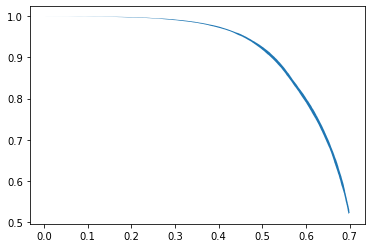

In [59]:
# Example usage.

plot_pareto_with_std(
    x_mean=resampled_mean['flat_softmax']['info_recall'],
    x_std=resampled_std['flat_softmax']['info_recall'],
    y_mean=resampled_mean['flat_softmax']['correct'],
    y_std=resampled_std['flat_softmax']['correct'],
    num_std=1.96,
    # x_grid=np.linspace(0, 1, 101),
)

In [60]:
def plot_metrics(x, y, tickres=None, save=False, xlim=None, ylim=None, figsize=(5, 4)):
    line_handles = []
    point_handles = []
    first_line = True
    plt.figure(figsize=figsize)

    for method_name in trials:
        method_trials = [
            trial_name for trial_name in trials[method_name]
            if (method_name, trial_name) in results
        ]
        # print('num trials:', len(method_trials))
        if not trial_names:
            continue

        # Plot errorbars.
        plot_pareto_with_std(
            x_mean=resampled_mean[method_name][x],
            y_mean=resampled_mean[method_name][y],
            x_std=resampled_std[method_name][x],
            y_std=resampled_std[method_name][y],
            alpha=0.333)

        ge = (score_grid >= 0.5)
        le = (score_grid <= 0.5)
        plt.plot(
            resampled_mean[method_name][x][le], resampled_mean[method_name][y][le],
            color=colors[method_name], linestyle='--')
        h = plt.plot(
            resampled_mean[method_name][x][ge], resampled_mean[method_name][y][ge],
            color=colors[method_name], label=method_titles.get(method_name, method_name))
        line_handles.extend(h)

        for inference_name in infer_fns:  # pred_metrics_mean[x][method_name].keys():
            h, = plt.plot(
                pred_metrics_mean[x][inference_name][method_name],
                pred_metrics_mean[y][inference_name][method_name],
                color=colors[method_name], linestyle='none',
                marker=markers[inference_name], markerfacecolor='none',
                label=inference_titles.get(inference_name, inference_name))
            if first_line:
                point_handles.append(h)
        first_line = False

    plt.grid('on')
    plt.xlabel(metric_titles.get(x, x))
    plt.ylabel(metric_titles.get(y, y))
    ax = plt.gca()

    if xlim:
        plt.xlim(**xlim)
    if ylim:
        plt.ylim(**ylim)
    # plt.ylim(np.clip(plt.ylim(), 0, 1))
    # plt.xlim(np.clip(plt.xlim(), 0, 1))
    if tickres:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tickres))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(tickres))
    # plt.axis('equal')
    # plt.gca().set_aspect(1)

    if save:
        pathlib.Path(PLOT_DIR).mkdir(parents=True, exist_ok=True)
        plt.savefig(pathlib.Path(PLOT_DIR) / f'{x}-{y}.pdf')
        main_fig = plt.gcf()
        plt.figure(figsize=figsize)
        plt.legend(handles=[*line_handles, *point_handles], loc='center left')
        plt.axis('off')
        plt.savefig(pathlib.Path(PLOT_DIR) / f'{x}-{y}-legend.pdf')
        plt.close()
        plt.figure(main_fig.number)

    plt.legend(handles=[*line_handles, *point_handles], loc='lower left')
    plt.show()

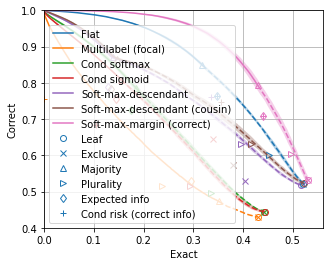

In [61]:
plot_metrics('exact', 'correct', tickres=0.1, xlim=dict(left=0), ylim=dict(top=1, bottom=0.4), save=True)

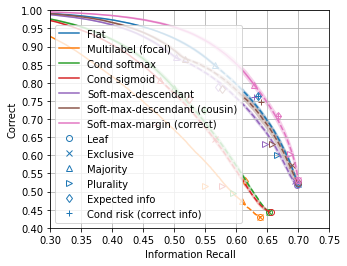

In [62]:
plot_metrics('info_recall', 'correct', tickres=0.05, xlim=dict(left=0.3, right=0.75), ylim=dict(bottom=0.4, top=1), save=True)

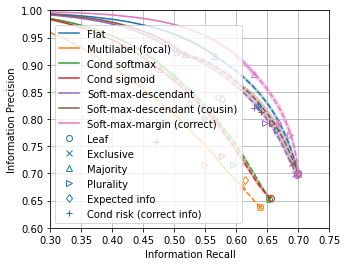

In [63]:
plot_metrics('info_recall', 'info_precision', tickres=0.05, xlim=dict(left=0.3, right=0.75), ylim=dict(bottom=0.6, top=1), save=True)

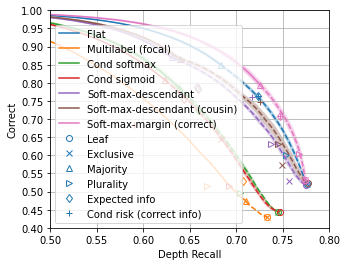

In [64]:
plot_metrics('depth_recall', 'correct', tickres=0.05, xlim=dict(left=0.5, right=0.8), ylim=dict(bottom=0.4, top=1), save=True)

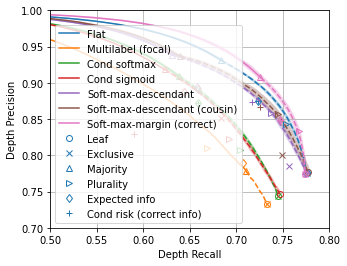

In [65]:
plot_metrics('depth_recall', 'depth_precision', tickres=0.05, xlim=dict(left=0.5, right=0.8), ylim=dict(bottom=0.7, top=1), save=True)